# SAT Optics Simulation: Far-Field

This notebook models the far-field beam of the Small Aperture Telescope.  We use the near-field beam simulated in the $\verb|sat_holography|$ notebook and the fourier relationship between near- and far-fields to propagate this beam into the far-field. 

Grace E. Chesmore
March 2022

### Read in the near-field beam


In [10]:
import numpy as np
import matplotlib
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interpolate

# %load_ext blackcellmagic

font_manager.fontManager.addfont(
    "/home/chesmore/.local/share/fonts/HelveticaNeueLight.ttf"
)
matplotlib.rcParams["font.family"] = "Helvetica Neue"
matplotlib.rcParams["font.size"] = 16
matplotlib.rcParams.update({"axes.grid" : False, "grid.color": "grey", "grid.alpha": .2, 'xtick.direction':'in','ytick.direction':'in'})
%config InlineBackend.figure_format = 'retina'

import imp
ot_geo = imp.load_source('ot_geo', '/home/chesmore/Desktop/Code/sosat-optics/sosat_optics/ot_geo.py')
ray_trace = imp.load_source('ray_trace', '/home/chesmore/Desktop/Code/sosat-optics/sosat_optics/ray_trace.py')
opt_analyze = imp.load_source('opt_analyze', '/home/chesmore/Desktop/Code/sosat-optics/sosat_optics/opt_analyze.py')

tele_geo = ot_geo.LatGeo()
tele_geo.n_scan = 200
tele_geo.y_source = ot_geo.y_lyot + 40

output_rx = ray_trace.rx_to_lyot([0, 0, 0], tele_geo, 0, "b")

len_sim = int(np.sqrt(len(output_rx[0])))
x_sim = np.reshape(output_rx[0], (len_sim, len_sim))  # [mm]
y_sim = np.reshape(output_rx[2], (len_sim, len_sim))  # [mm]

indx_x = np.where((np.isnan(x_sim)==False) & (abs(x_sim)<=250))
indx_y = np.where((np.isnan(y_sim)==False) & (abs(y_sim)<=250))

x_sim_new = np.linspace(np.min(x_sim[indx_x]),np.max(x_sim[indx_x]),len_sim)
y_sim_new = np.linspace(np.min(y_sim[indx_y]),np.max(y_sim[indx_y]),len_sim)
x_sim,y_sim = np.meshgrid(x_sim_new,y_sim_new)

a_sim = np.reshape(output_rx[4], (len_sim, len_sim))
p_sim = np.reshape(output_rx[3], (len_sim, len_sim))
p_sim = np.mod(tele_geo.k * (p_sim - np.mean(p_sim)) / 1e3, 2 * np.pi)

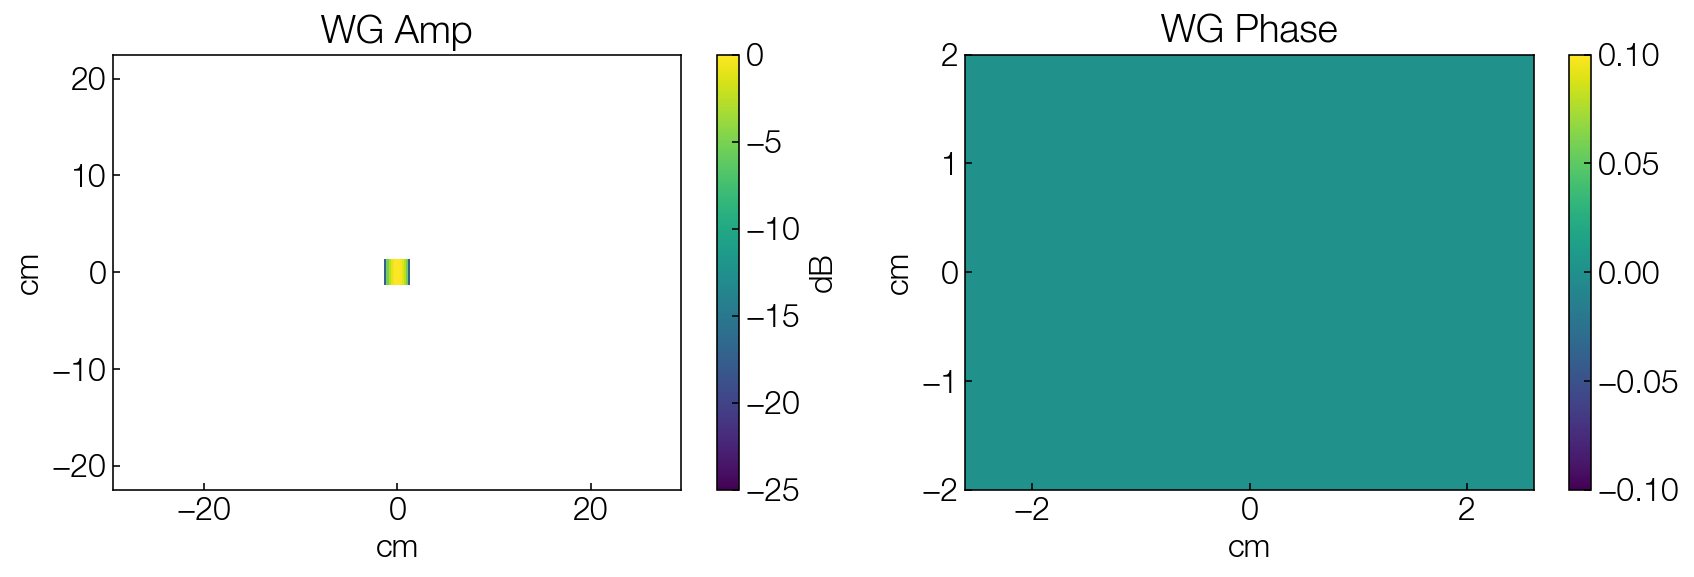

/home/chesmore/Desktop/Code/sosat-optics/sosat_optics/opt_analyze.py:56: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(x,y,10*np.log10(abs(disc_fft)/np.max(abs(disc_fft))),vmin = -25,shading = 'auto')


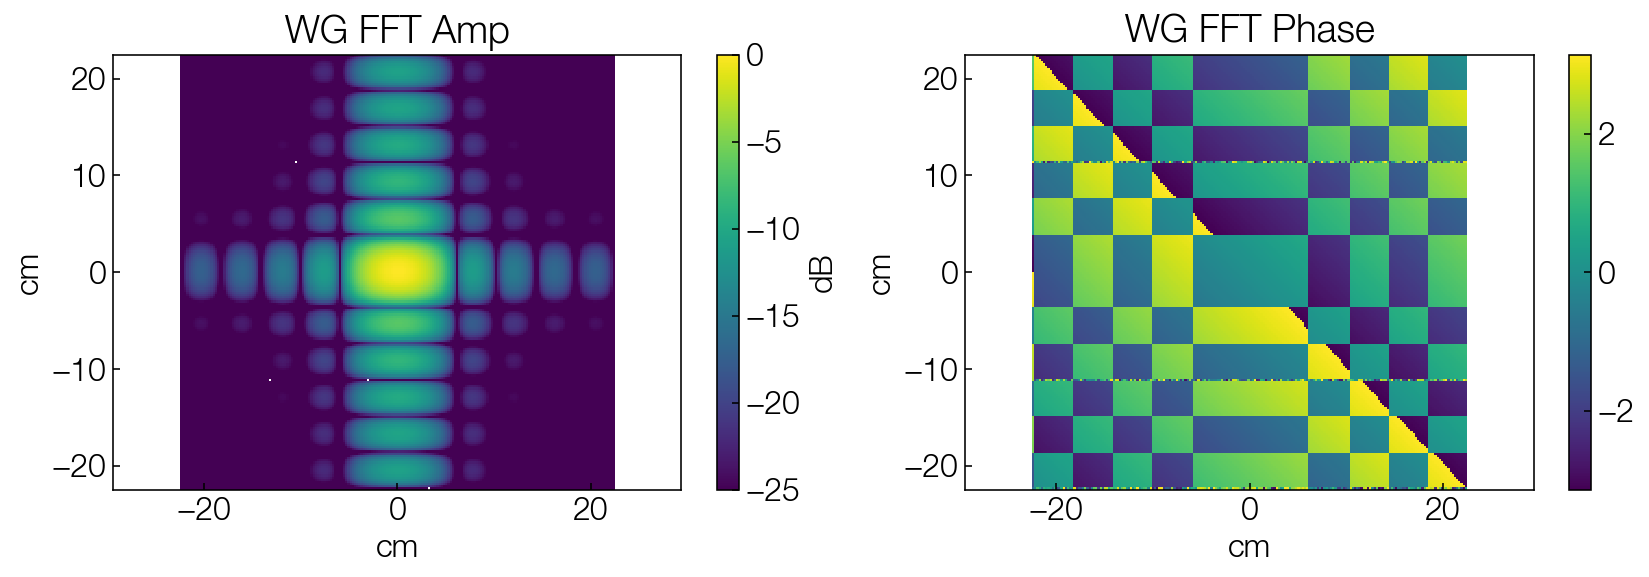

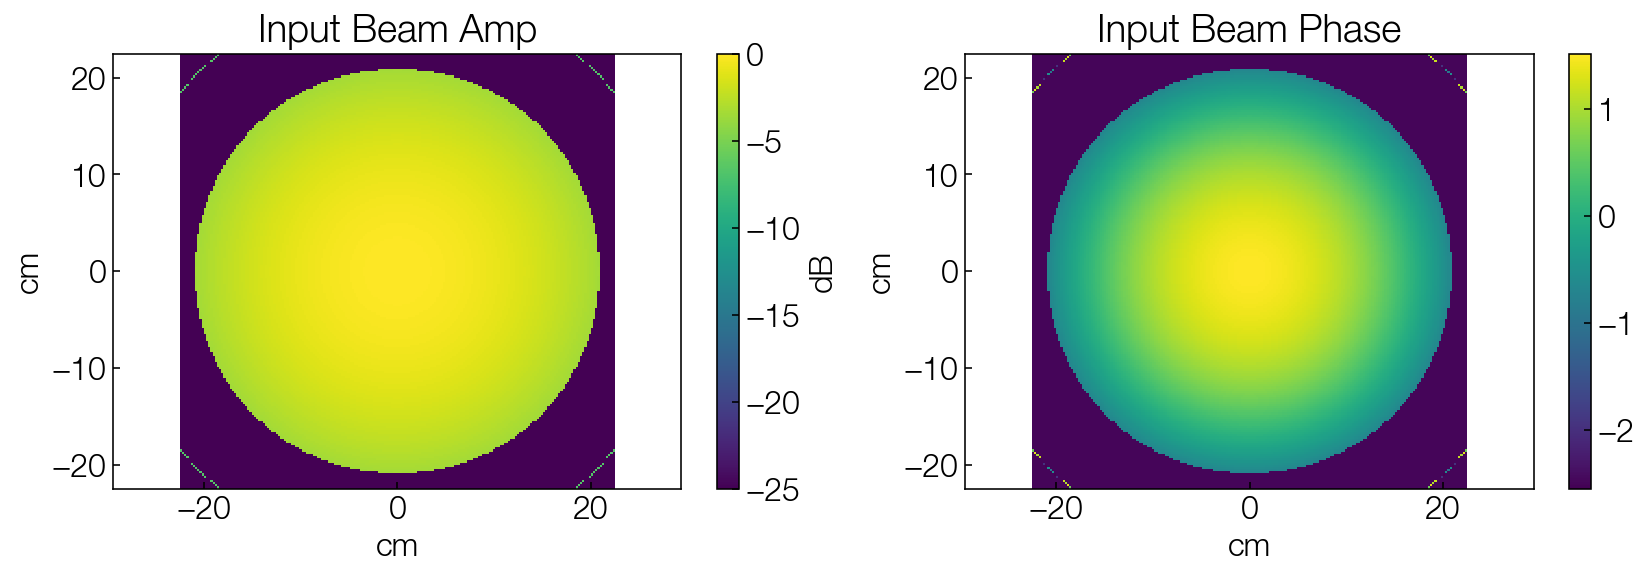

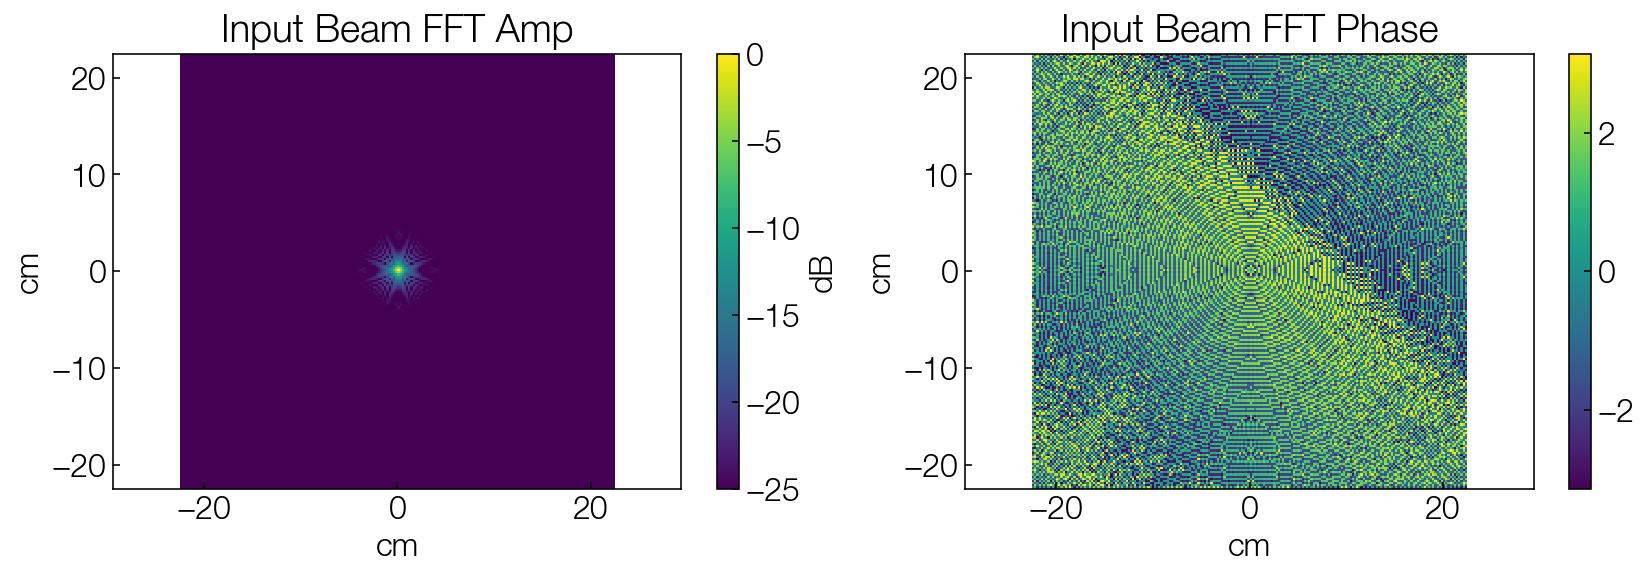

/home/chesmore/Desktop/Code/sosat-optics/sosat_optics/opt_analyze.py:106: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(x,y,10*np.log10(abs(beam_conv)/np.max(abs(beam_conv))),vmin = -25,shading = 'auto')


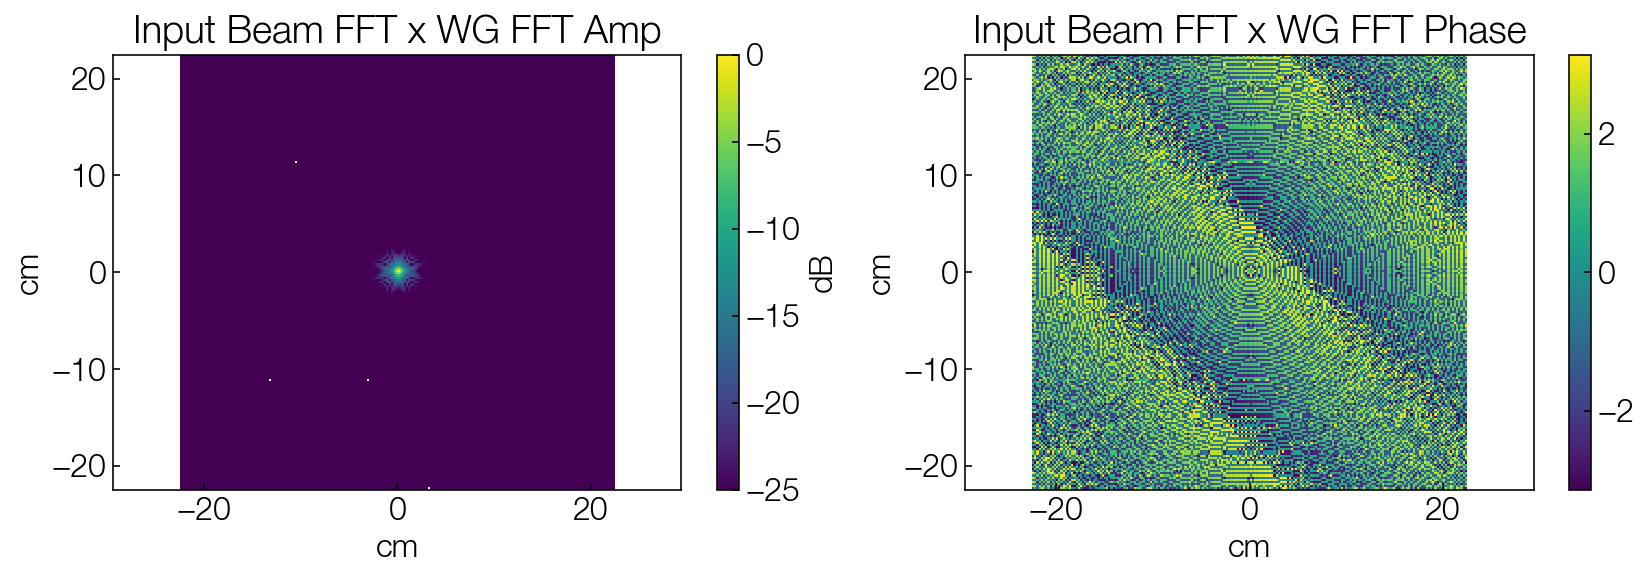

In [11]:
# Define the complex beam from ray-trace outputs
noise = 1e-6 # signal-to-noise of holography setup
a_sim /= np.max(abs(a_sim))
a_sim += noise
beam_sim = a_sim * np.exp(complex(0, 1) * p_sim)

# Define the dimmensions of the waveguide
apert1 = 2.5 # [cm]
apert2 = 2.5 # [cm]

x = np.real(x_sim)/1e1
y = np.real(y_sim)/1e1
beam_final = beam_sim
# Convolve beam
x, y, beam_final = opt_analyze.beam_convolve(
    np.real(x_sim)/1e1, np.real(y_sim)/1e1, beam_sim, apert1, apert2,0
)

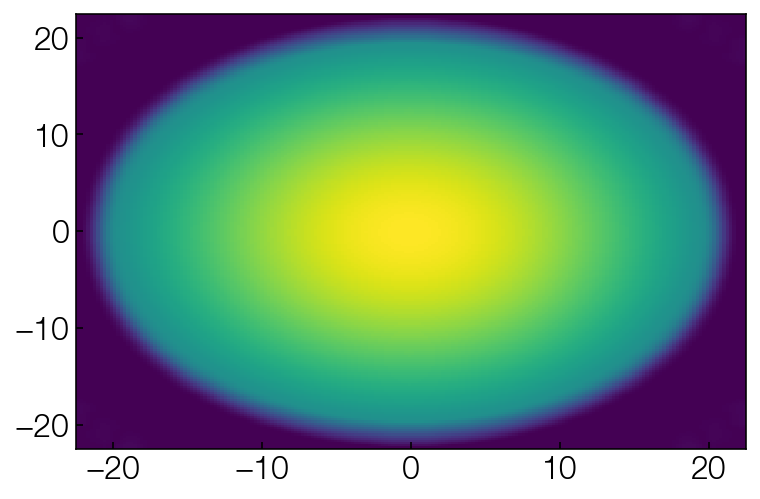

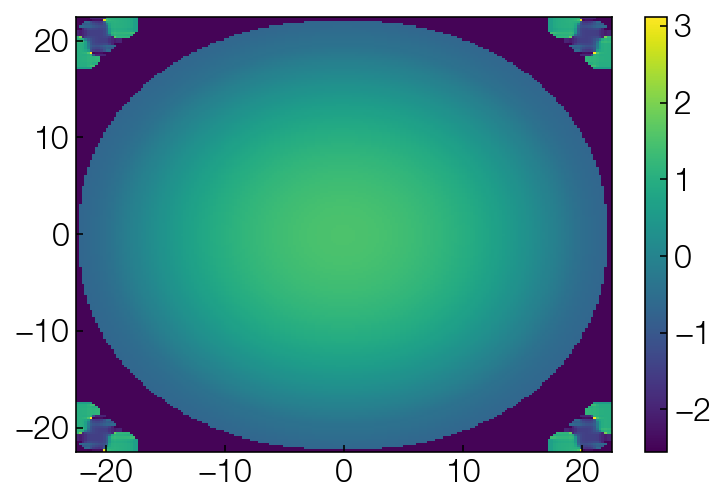

In [12]:
plt.pcolormesh(x, y, abs(beam_final),shading = 'auto')
plt.show()

plt.pcolormesh(x, y,np.arctan2(np.imag(beam_final),np.real(beam_final)),shading = 'auto')
plt.colorbar()
plt.show()

In [13]:
x_int = abs(x[0,0]-x[0,1])
y_int = abs(y[0,0]-y[1,0])

## Zero padding 

In [14]:
x_int = abs(x[0,0]-x[0,1])
y_int = abs(y[0,0]-y[1,0])

In [19]:
x_int = abs(x_new[0,0]-x_new[0,1])
y_int = abs(y_new[0,0]-y_new[1,0])
beam_final = np.pad(beam_final, 500, mode='constant')
x_new = np.array(np.arange(len(beam_final)))
y_new = np.array(np.arange(len(beam_final)))
x_new = x_new - np.mean(x_new)
y_new = y_new - np.mean(y_new)
x_new = x_new * x_int
y_new = y_new * y_int

x_new,y_new = np.meshgrid(x_new,y_new)

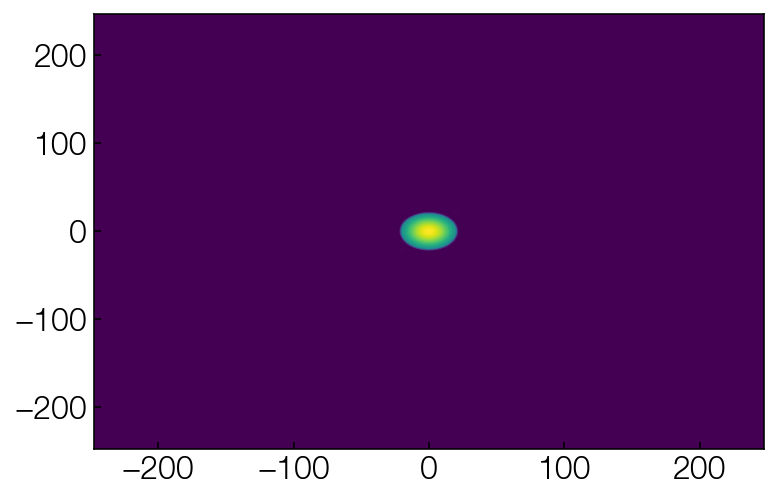

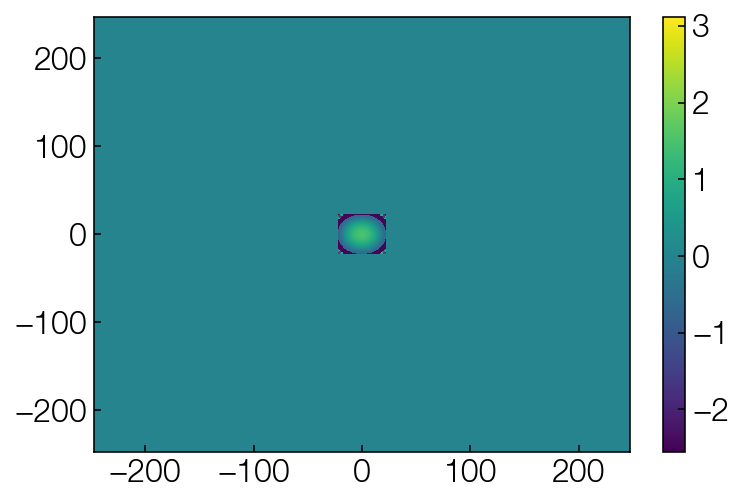

In [20]:
plt.pcolormesh(x_new, y_new, abs(beam_final),shading = 'auto')
plt.show()

plt.pcolormesh(x_new, y_new,np.arctan2(np.imag(beam_final),np.real(beam_final)),shading = 'auto')
plt.colorbar()
# plt.xlim(-250,250)
# plt.ylim(-250,250)
plt.show()

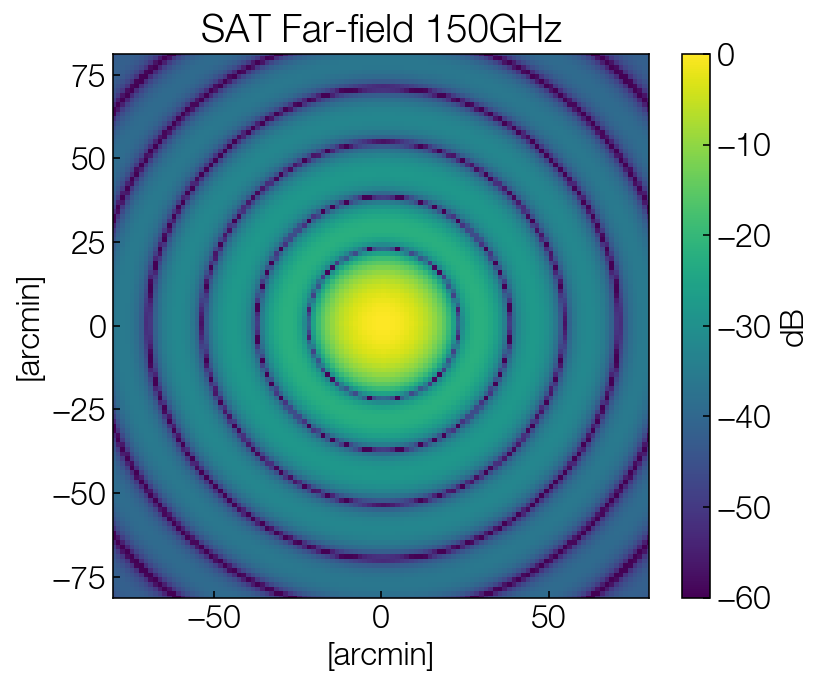

In [21]:
phase = np.arctan2(np.imag(beam_final),np.real(beam_final))*0
beam_fft,phase_fft = opt_analyze.a2b(beam_final, phase)
freq = 150

x_ang,y_ang = opt_analyze.coords_spat_to_ang(x_new/1e2, y_new/1e2, freq)

plt.figure(figsize = (6,5))
plt.title("SAT Far-field 150GHz")
plt.pcolormesh(x_ang*180*60/np.pi,y_ang*180*60/np.pi,20*np.log10(abs(beam_fft)/np.max(abs(beam_fft))),vmin = -60,shading = 'auto')
plt.xlabel("[arcmin]")
plt.ylabel("[arcmin]")
plt.colorbar(label = "dB")
plt.axis("equal")
plt.xlim(-80,80)
plt.ylim(-80,80)
plt.show()

In [22]:
a = abs(beam_fft)**2 /np.max(abs(beam_fft)**2)
x_out = y_ang
y_out = x_ang

indx = np.where(abs(a)==np.max(abs(a)))
x = y_out[indx[0][0],:]*60*180/np.pi
y = ((abs(a)[indx[0][0],:]/np.max(abs(a))))
v1 = (x[np.where((y>.5))][0])
v2 = (x[np.where((y>.5))][-1])

fwhm1 = (abs(v1-v2))

indx = np.where(abs(a)==np.max(abs(a)))
x = x_out[:,indx[1][0]]*60*180/np.pi
y = ((abs(a)[:,indx[1][0]]/np.max(abs(a))))
v1 = (x[np.where((y>.5))][0])
v2 = (x[np.where((y>.5))][-1])

fwhm2 = (abs(v1-v2))

print( (fwhm1 + fwhm2) /2)

16.694294080089854


In [23]:
print((1.025*.002 / .42)*180*60/np.pi)

16.779478285974108
